## Exploratory data analysis

In [1]:
import subprocess
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Merge all results into one file.
run = subprocess.run(["py", "process_data.py", "--mode=merge"])
print(run)
assert run.returncode == 0

CompletedProcess(args=['py', 'process_data.py', '--mode=merge'], returncode=0)


In [3]:
def load_repo_csv(repo_file):
    repo = pd.read_csv(f"data/results/{repo_file}", index_col=0)
    repo['date'] = pd.to_datetime(repo['date'], utc=True)
    return repo

Dataframes for individual repositories.

In [4]:
repo_files = list(set(os.listdir("data/results")) - {"_all_results.csv", "tiny"})

max_repos_load = 5
repos = {repo_file: load_repo_csv(repo_file) for repo_file in repo_files[:max_repos_load]}
repos.keys()

dict_keys(['easydict.csv', 'plac.csv', 'backports.os.csv', 'python-atomicwrites.csv', 'sqlite-utils.csv'])

Dataframe for all results.

In [5]:
all_results = pd.read_csv("data/results/_all_results.csv", index_col=0)
all_results['date'] = pd.to_datetime(all_results['date'], utc=True)

all_results.describe()["radon_LOC"]

count    43218.000000
mean      7658.685224
std       8037.240018
min          0.000000
25%       1448.000000
50%       4295.000000
75%      11997.000000
max      45922.000000
Name: radon_LOC, dtype: float64

In [6]:
all_results.head()

,hash,author,date,commit_message,is_merge,lines_changed,insertions,deletions,dmm_unit_size,dmm_unit_complexity,...,radon_avg_cc,radon_avg_MI,radon_avg_vocabulary,radon_avg_length,radon_avg_volume,radon_avg_difficulty,radon_avg_effort,radon_avg_time,radon_avg_bugs,repo_name
ID,,,,,,,,,,,,,,,,,,,,,
0,1c6972eef4d4dc774fa50f29248f776fa6628e9e,Yilei Yang,2017-09-19 21:25:01+00:00,Initial commit: Abseil Python Common Libraries.,False,22843,22843,0,0.544562,0.767955,...,1.956307,65.930709,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
1,e8d3808145a248845098dea839b1ff6753981f18,Yilei Yang,2017-09-25 17:28:32+00:00,Move the --only_check_args check earlier. So ...,False,14,12,2,1.000000,1.000000,...,1.955519,65.918611,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
2,a03c793c3db4d35cac68953c4207e1929881362c,Yilei Yang,2017-09-25 17:29:23+00:00,Fix FLAGS.set_default's docstring. It only se...,False,7,4,3,NaN,NaN,...,1.955519,65.918328,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
3,9b5d766f40f8ff1d2c74c88b95340fdc01a42ef2,Yilei Yang,2017-09-25 17:29:56+00:00,Code cleanup. PiperOrigin-RevId: 169707068,False,5,1,4,NaN,NaN,...,1.955519,65.918655,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
4,99d72774ba05271cf2aa6d9cf80da8508ae48d59,Yilei Yang,2017-09-25 17:31:47+00:00,Clean up unused code. PiperOrigin-RevId: 1697...,False,15,1,14,1.000000,1.000000,...,1.955519,65.919108,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py


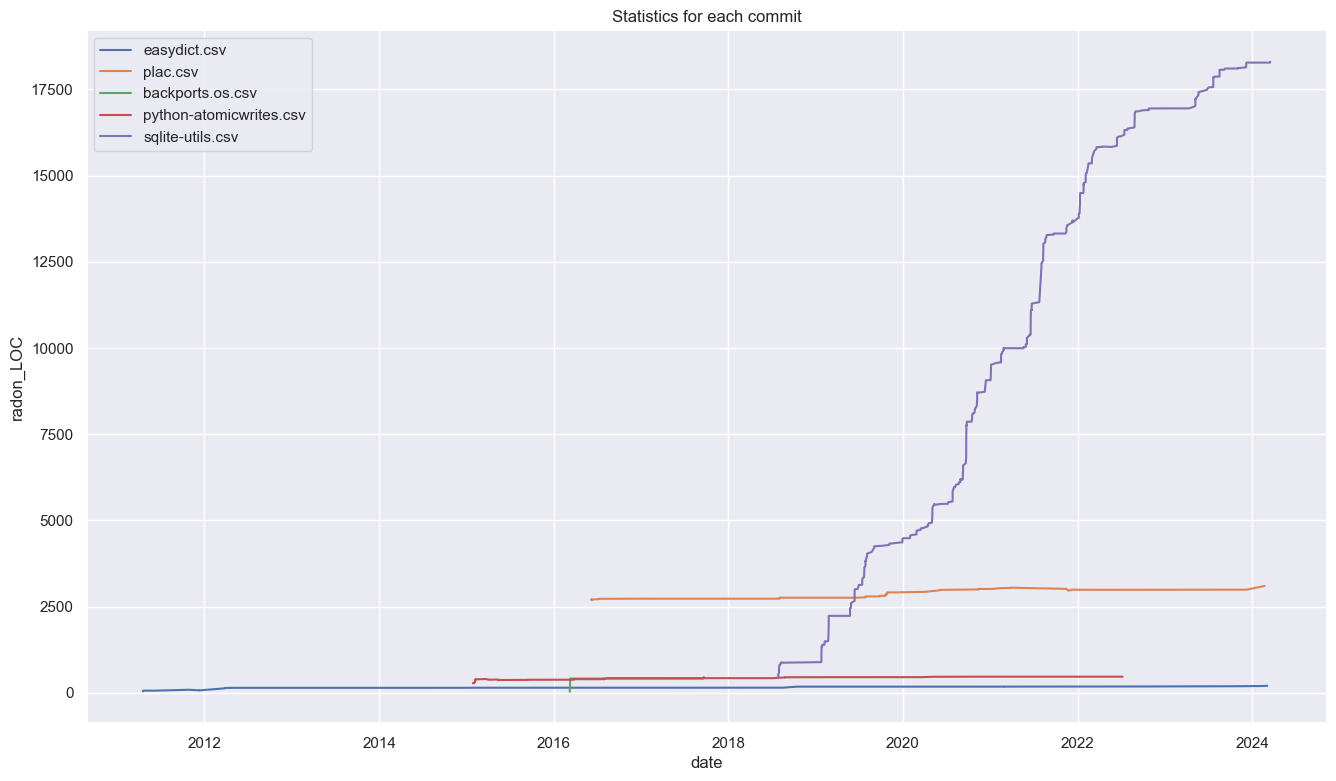

In [7]:
sns.set_theme(rc={'figure.figsize':(16,9)})

# Sample codebase size throughout time.
for repo_name, df in repos.items():
    sns.lineplot(data=df, x='date', y='radon_LOC', label=repo_name)
plt.title("Statistics for each commit");

Shapley analysis.

In [8]:
import json

import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import shap

In [9]:
DATA_FILE = "data/results/_all_results.csv"

cols = ["lines_changed", "insertions", "deletions", "radon_LOC", "radon_LLOC", "radon_SLOC", "radon_comments", "radon_avg_cc", "radon_avg_MI", "radon_avg_vocabulary", "radon_avg_length", "radon_avg_volume", "radon_avg_difficulty", "radon_avg_effort", "radon_avg_time", "radon_avg_bugs"]
data = pd.read_csv(DATA_FILE, usecols=cols)

# Map feature names for readability.
with open("feature-label-map.json", "r") as f:
    feature_label_map = json.load(f)
data.rename(columns=feature_label_map, inplace=True)

y = data["LOC"]
X = data.drop(["LOC", "LLOC", "SLOC", "Comments"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)

# Hyperparameters for the LightGBM model.
lgbm_params = {
    "objective": "regression",
    "metrics": ["rmse", "mape"],
    "verbose": 0
}

model = lgb.train(lgbm_params, train_data, num_boost_round=1000)

# Cross-validation.
cv_metrics = lgb.cv(lgbm_params, train_data, )

for metric, values in cv_metrics.items():
    print(f"mean of '{metric}': {np.mean(values)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


mean of 'valid rmse-mean': 3035.8716221289633
mean of 'valid rmse-stdv': 43.59722777439147
mean of 'valid mape-mean': 1.506719291224345
mean of 'valid mape-stdv': 0.09841793216187059


In [18]:
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 626688.6545301098
Root Mean Squared Error: 791.6366935217883
Mean Absolute Error: 452.2654347918451
R-squared: 0.9901150130424099


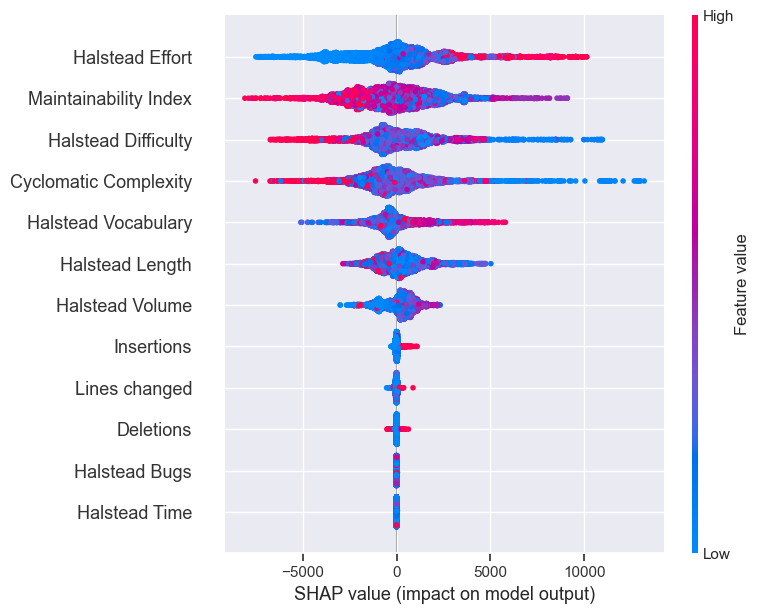

In [11]:
explainer = shap.Explainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

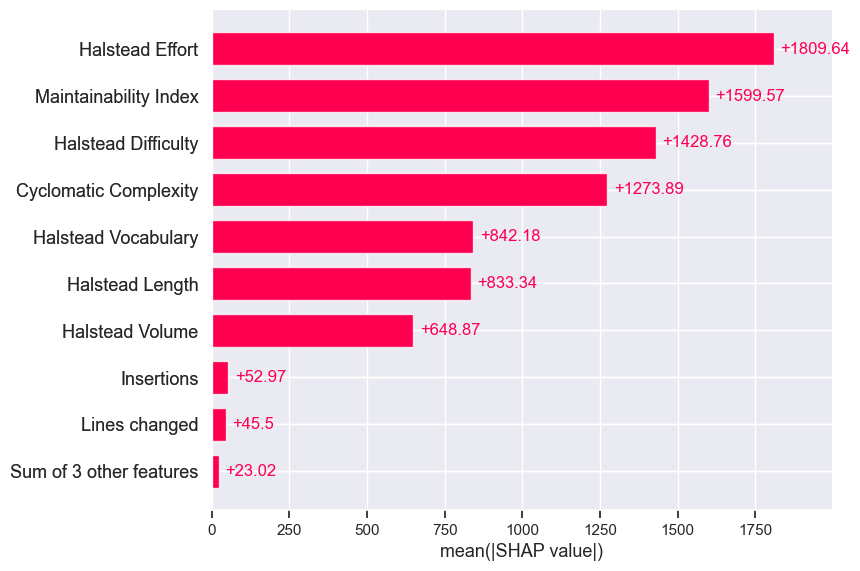

In [12]:
shap.plots.bar(explainer(X_test))

In [13]:
# Mean Shapley values for each feature. Manual version of SHAP bar plot.
mean_shapley_values = np.abs(shap_values).mean(0)
for col, val in zip(X_test.columns, mean_shapley_values):
    print(f"{col}: {val}")

Lines changed: 45.50396021761693
Insertions: 52.97067460716732
Deletions: 23.01813997571938
Cyclomatic Complexity: 1273.8937030277314
Maintainability Index: 1599.5650889081521
Halstead Vocabulary: 842.176309344552
Halstead Length: 833.3360023475107
Halstead Volume: 648.8715464262011
Halstead Difficulty: 1428.7623020001158
Halstead Effort: 1809.6446978454073
Halstead Time: 0.0
Halstead Bugs: 0.0


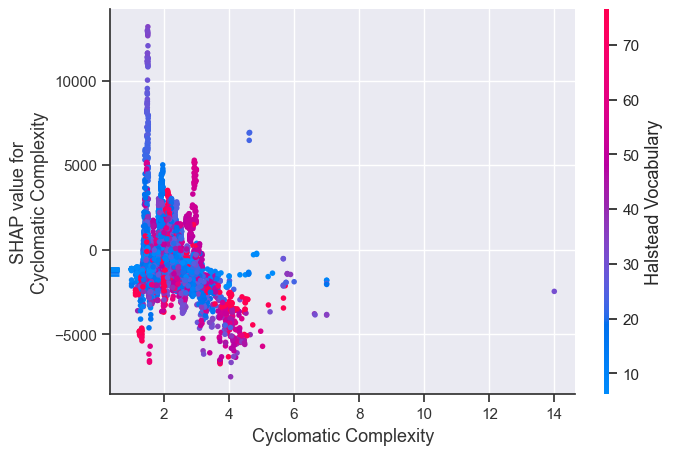

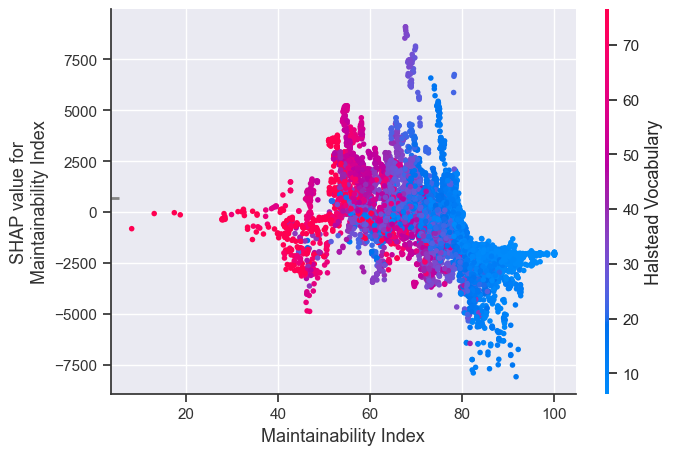

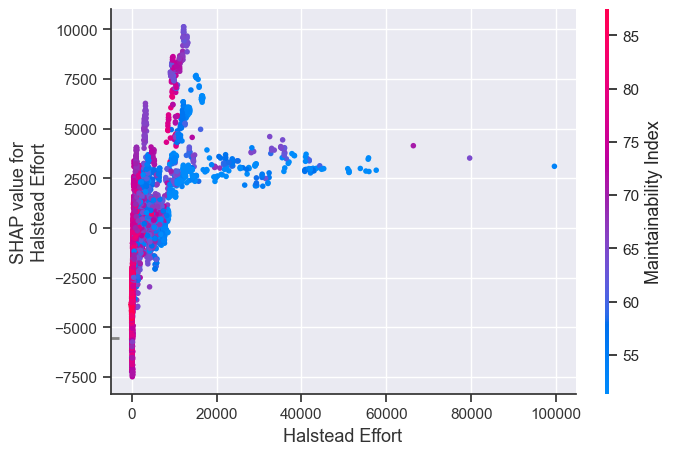

In [14]:
# Dependence plot for specific feature.
features = ["Cyclomatic Complexity", "Maintainability Index", "Halstead Effort"]
for feature in features:
    shap.dependence_plot(feature, shap_values, X_test)

{0: 'Lines changed', 1: 'Insertions', 2: 'Deletions', 3: 'Cyclomatic Complexity', 4: 'Maintainability Index', 5: 'Halstead Vocabulary', 6: 'Halstead Length', 7: 'Halstead Volume', 8: 'Halstead Difficulty', 9: 'Halstead Effort', 10: 'Halstead Time', 11: 'Halstead Bugs'}
Shapley Values for Single Instance:
[[ -100.0868289    -34.38415822   -16.19764041 -2746.21808401
   -522.36214114 -1320.79369641  -190.23722052   250.60771843
  -1883.30834355  -373.21071913     0.             0.        ]]


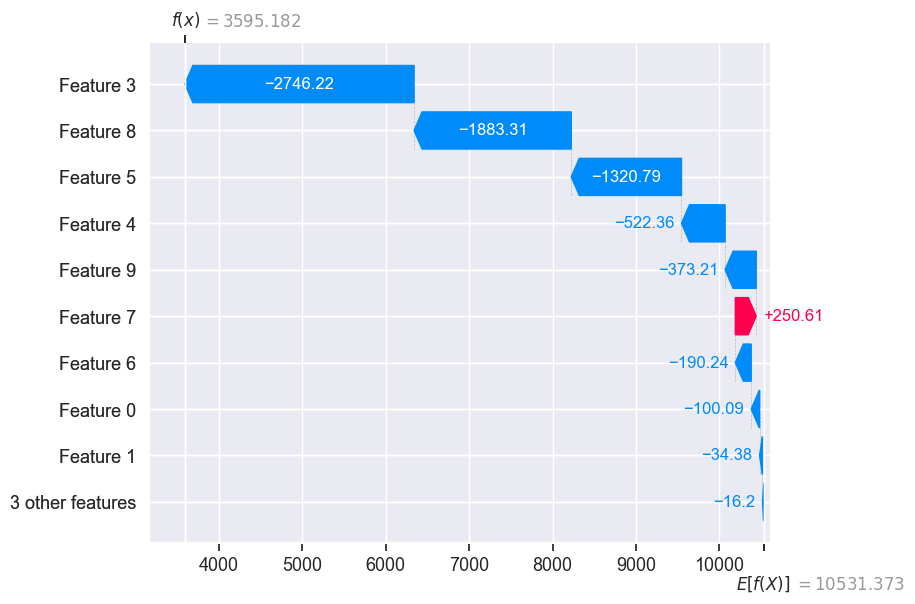

In [15]:
# instance = X_test.iloc[0].values.reshape(1, -1)
# shap_values_single = explainer.shap_values(instance)

print({i: col for i, col in enumerate(X_test.columns)})
# Calculate the Shapley values for a single instance.
instance = X_test.iloc[4].values.reshape(1, -1)
shap_values_single = explainer.shap_values(instance)

print("Shapley Values for Single Instance:")
print(shap_values_single)


shap.waterfall_plot(shap.Explanation(values=shap_values_single[0], base_values=model.predict(X_train.mean().values.reshape(1, -1))), )

<Axes: xlabel='LOC'>

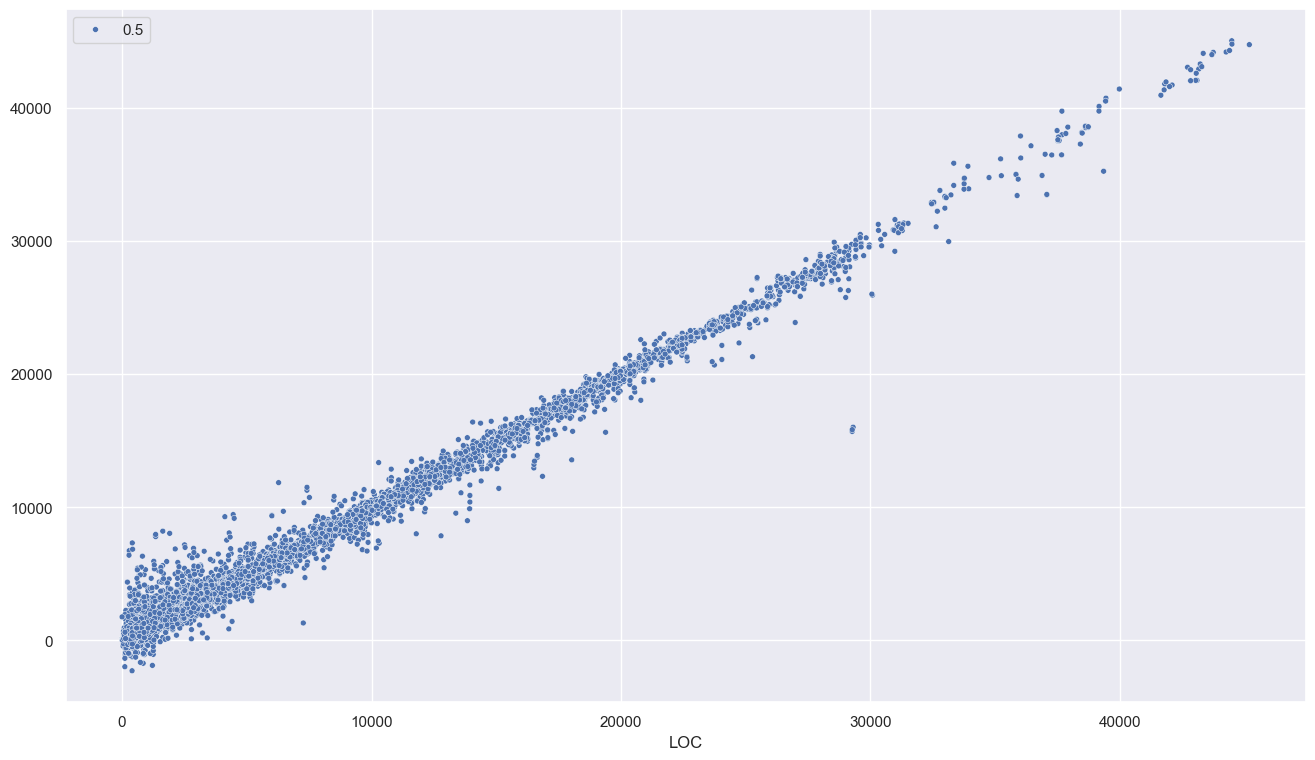

In [24]:
sns.scatterplot(x=y_test, y=y_pred_test, size=0.5)